# Explore faces from Adience

1. Faces
2. Ages
3. Genders
4. Tilt - we will remove them from training
5. Facial keypoints - we will crop out faces

### imports

In [21]:
import os,sys
import importlib
import pandas as pd
import numpy as np
import glob
import cv2

import skimage
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tqdm import tqdm

In [23]:
%load_ext autoreload

%autoreload 2

In [4]:
project_dir = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
if not project_dir in sys.path: sys.path.append(project_dir)

In [25]:
plot = importlib.import_module('src.rgutils.plot', project_dir)

### Load data

In [10]:
DATA_DIR = '../data/external/adience/faces/'
labels_dir = '../data/external/adience/'
num_folds = 5

In [ ]:
# %load ../src/adience/adience_utils.py
import os
import pandas as pd
import numpy as np
import skimage
import cv2
from tqdm import tqdm


def get_image_path(table_row, data_dir):
    '''
    Get image path and correspoing landmarks for a row in labels table
    '''
    img_fname = '.'.join(['coarse_tilt_aligned_face', str(table_row['face_id']), table_row['original_image']])
    lmk_fname = img_fname.replace('coarse_tilt_aligned_face', 'landmarks')
    lmk_fname = lmk_fname.replace('jpg', 'txt')
    img_path = os.path.join(data_dir, table_row['user_id'], img_fname)
    lmk_path = os.path.join(data_dir, table_row['user_id'], lmk_fname)
    return img_path, lmk_path


def load_labels(labels_dir, indices):
    '''
    Load label files by index
    '''
    fname = 'fold_{index}_data.txt'
    labels = pd.DataFrame()
    for i in indices:
        path = os.path.join(labels_dir, fname.format(index = i))
        tmp = pd.read_table(path, usecols=['user_id','original_image','face_id','tilt_ang','age','gender'])
        tmp['fold'] = i
        labels = labels.append(tmp)
    return labels


def facial_keypoints(image_paths, keypoint_paths, num_random=None, 
                     keypoints=True, crop=False):
    images = []
    if num_random:
        indices = np.random.choice(range(len(image_paths)),  size=num_random)
        image_paths = np.array(image_paths)[indices]
        keypoint_paths = np.array(keypoint_paths)[indices]
    for ip,kp in tqdm(zip(image_paths, keypoint_paths)):
        img = skimage.io.imread(ip)
        lmk = pd.read_table(kp, skiprows=1, sep=',')
        if keypoints:
            for _,row in lmk.iterrows():
                loc = (int(row['x_c']),int(row['y_c']))
                cv2.circle(img, loc, radius=3, color=(255,0,0), thickness=3)
        if crop:
            left,top,right,bottom = keypoint_bounds(lmk['x_c'], lmk['y_c'])
            img = img[top:bottom, left:right, :]
        images.append(img)
    return images


def keypoint_bounds(x_values, y_values):
    '''
    From an array of x and y
    Return: left,top,right,bottom
    '''
    left = int(np.min(x_values))
    top = int(np.min(y_values))
    right = int(np.max(x_values))
    bottom = int(np.max(y_values))
    return left,top,right,bottom


In [15]:
indices = list(range(num_folds))

In [16]:
labels = load_labels(labels_dir, indices)

labels.shape

(19370, 7)

In [17]:
labels.head()

,user_id,original_image,face_id,age,gender,tilt_ang,fold
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,-115,0
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,0,0
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,175,0
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,180,0
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,-75,0


In [63]:
image_paths = [get_image_path(row, DATA_DIR)[0] for _,row in labels.iterrows()]
lmk_paths = [get_image_path(row, DATA_DIR)[1] for _,row in labels.iterrows()]

len(image_paths), len(lmk_paths)

(19370, 19370)

### Explore images

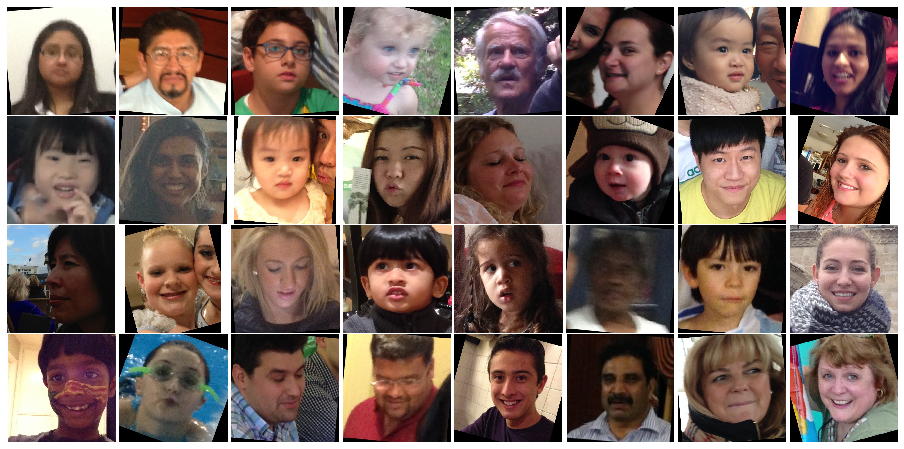

In [46]:
plot.show_images(image_paths, 4, 8, fig_dims=(16, 8))

##### Ages

In [49]:
image_ages = list(zip(image_paths, labels['age']))

len(image_ages)

19370

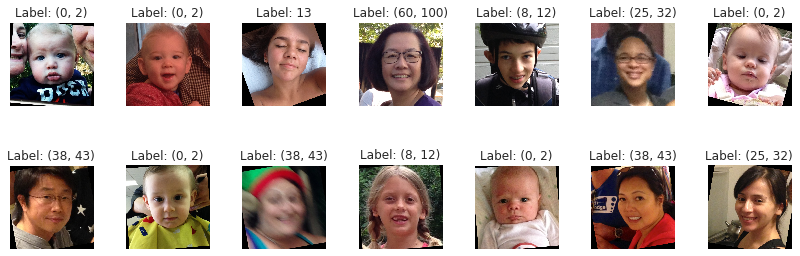

In [54]:
plot.image_labels_grid(2, 7, image_ages, fig_dims=(14,5))

##### Gender

In [55]:
image_gender = list(zip(image_paths, labels['gender']))

len(image_gender)

19370

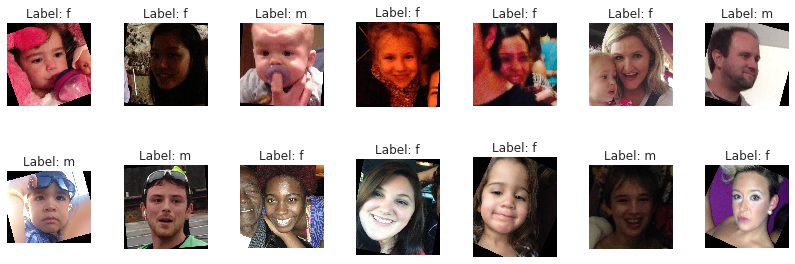

In [56]:
plot.image_labels_grid(2, 7, image_gender, fig_dims=(14,5))

##### Tilt

In [57]:
image_tilt = list(zip(image_paths, labels['tilt_ang']))

len(image_tilt)

19370

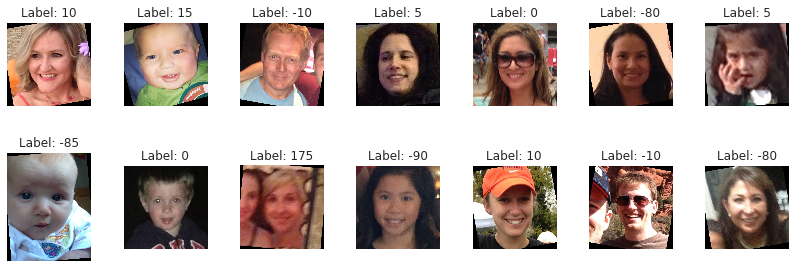

In [60]:
plot.image_labels_grid(2, 7, image_tilt, fig_dims=(14,5))

##### Facial keypoints

In [110]:
keypoint_images = facial_keypoints(image_paths, lmk_paths, num_random=50)

50it [00:00, 70.49it/s]


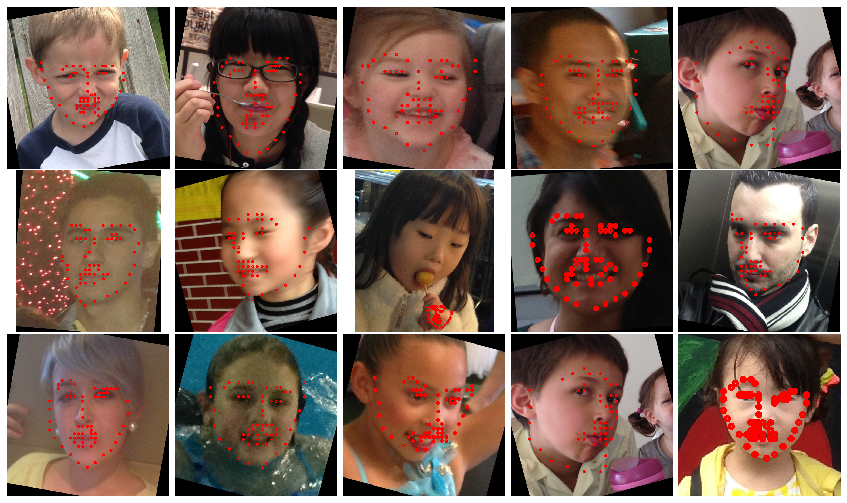

In [111]:
plot.show_images(keypoint_images, 3, 5, fig_dims=(15,9))

##### Facial keypoints cropped

In [123]:
keypoint_images = facial_keypoints(image_paths, lmk_paths, num_random=50,
                                   crop=True, keypoints=False)

crop_sizes = [f'dx {img.shape[1]}, dy {img.shape[0]}' for img in keypoint_images]

50it [00:00, 67.88it/s]


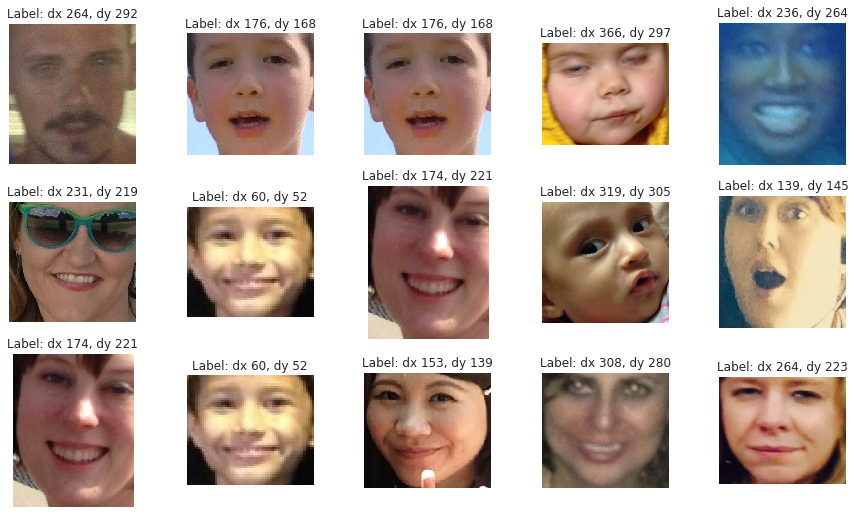

In [125]:
plot.image_labels_grid(3,5, list(zip(keypoint_images, crop_sizes)), fig_dims=(15,9),)